In [29]:
import torch
import torch.nn as nn
import torchvision
import torch.optim as optim
# from torch.optim import lr_scheduler
from torchvision import datasets, transforms
from IPython.display import display, clear_output
import matplotlib.pyplot as plt
import torch.nn.functional as F
import numpy as np
import math
import random



''' Device config'''
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

''' Parameters (CHange Anything Here!) '''
transform = transforms.ToTensor()
batch_size = 150
# lifetime Sparcity
k_rate = 0.05

''' Conv 2d Layer 
#         Accessible Variables: .weights(Tensor), .bias(Tensor)
#         parameters :
#         torch.nn.Conv2d(in_channels, out_channels, 
#                         kernel_size, stride=1, padding=0, 
#                         dilation=1, groups=1, bias=True, 
#                         padding_mode='zeros')
'''
# CONV-WTA CRITERIA
# - zero padded, so that each feature map has the same size as the input
# - hidden representation is mapped linearly to the output using a deconvolution operation
# - Parameters are optimized to reduce the mean squared error MSE
# - Conv layer is 5 x5, DECONVOLUTION layer is using filters of 11x 11
### In this implementation, I will not use deconvolution, but transpose convolution to ease process
class Competitive_Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()

        #Image size:N, 28, 28
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 81, 5, stride=1, padding = 2),     
            nn.ReLU(),
            nn.BatchNorm2d(81),
#             nn.Conv2d(81, 81, 5, stride=1, padding = 2),
#             nn.ReLU(),
#             nn.BatchNorm2d(81),
            nn.Conv2d(81, 81, 5, stride=1, padding = 2),
            nn.BatchNorm2d(81)
        )
        self.transConv1 = nn.ConvTranspose2d(in_channels=81, out_channels=1, kernel_size=11, stride =1, padding = 5) # padding will decrease output size # size:N, 28, 28
        
    def forward(self, x):
        encoded = self.encoder(x)
        winner = self.spatial_sparsity_(encoded)
        self.lifetime_sparsity_(encoded, winner, k_rate)
        decoded = self.transConv1(encoded)
        return decoded
    
    # Spatial Sparsity reconstructs the activation map, remain only one winner neuron of each feature map and rest to 0
    # with torch.no_grad() temporarily sets all of the requires_grad flags to false
    def spatial_sparsity_(self, hiddenMaps):
        with torch.no_grad():
            shape = hiddenMaps.shape  #torch.Size([batch_size, feature_num, 26, 26])
            n_batches = shape[0]
            n_features = shape[1]
            size = shape[2]
            
            # Step 1: flatten it out, find max_vals
            flatten = hiddenMaps.view(n_batches, n_features, -1)
            maxval, _ = torch.max(flatten, 2) # max_val return size[n_batches, n_features]
            
            # Step 2: creating "drop" Array to be multiplied into featureMaps, dropping loser values
            maxval_p = torch.reshape(maxval, (n_batches, n_features, 1, 1))
            drop = torch.where(hiddenMaps < maxval_p, 
                               torch.zeros((n_batches, n_features, size, size)).to(device), 
                               torch.ones((n_batches,n_features, size, size)).to(device))
        
        # To retain the graph, use .data to only modify the data of the tensor
        hiddenMaps.data = hiddenMaps.data*drop.data
        return maxval
        
    # Only retain the top-k percent of the winners for every feature. The rest will be zeroed out
    def lifetime_sparsity_(self, hiddenMaps, maxval, k_percent):
        with torch.no_grad():
            shape = hiddenMaps.shape  #torch.Size([batch_size, feature_num, 26, 26])
            n_batches = shape[0]
            n_features = shape[1]
            size = shape[2]
            k = 10
            
            top_k, _ = torch.topk(maxval, k, 0) 

            # Step 2: creating "drop" Array to be multiplied into featureMaps, dropping loser values
            drop = torch.where(maxval < top_k[k-1:k, :],  
                               torch.zeros((n_batches, n_features)).to(device), 
                               torch.ones((n_batches, n_features)).to(device))

        # To retain the graph, use .data to only modify the data of the tensor
        hiddenMaps.data = hiddenMaps.data * drop.reshape(n_batches, n_features, 1, 1).data
        
# Saving the state dicts of the model
def save_model_optimizer(model, optimizer = None, filename = "CompAutoModel", path = ""):
    temp_device = torch.device('cpu')
    if optimizer == None:
        torch.save({
            'model_state': model.state_dict()
        }, path+filename+".pth")
    else:
        torch.save({
            'model_state': model.state_dict(),
            'optim_state': optimizer.state_dict()
        }, path+filename+".pth")
    
def load_model(filename, path = ""):
    checkpoint = torch.load(path+filename+".pth", map_location = 'cpu')
    model_obj = Competitive_Autoencoder()
    model_obj.load_state_dict(checkpoint['model_state'])
    model_obj.eval()
        
    if len(checkpoint.keys()) == 1:
        return model_obj
    else:
        optim_obj = torch.optim.Adam(model_obj.parameters(), lr = 0)
        optim_obj.load_state_dict(checkpoint['optim_state'])
        return model_obj, optim_obj

In [30]:
''' Code Starts Here '''
# Declaring model and stuff
model = Competitive_Autoencoder().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)

# Data MNIST
mnist_data = datasets.MNIST(root='./data', train = True, download = True, transform = transform)
data_loader = torch.utils.data.DataLoader(dataset= mnist_data, batch_size = batch_size, shuffle = True)

In [31]:
# Saving the model (DONE)
write_path = "pth_and_results/81conv5-81conv5-81deconv11/"
# save_model_optimizer(model, optimizer, "81featuresLifetime5", write_path)



Epoch:1, Loss:0.0339
Epoch:2, Loss:0.0337
Epoch:3, Loss:0.0287
Epoch:4, Loss:0.0327
Epoch:5, Loss:0.0285
Epoch:6, Loss:0.0296
Epoch:7, Loss:0.0312
Epoch:8, Loss:0.0309
Epoch:9, Loss:0.0315
Epoch:10, Loss:0.0297
Epoch:11, Loss:0.0298
Epoch:12, Loss:0.0336


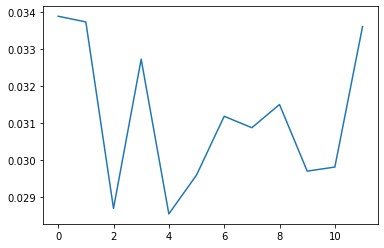

In [32]:
# Training Loop
''' Things to try:
- Increase epochs: 25 / (Finding: need to implement stop training methods)
- Include Lifetime Sparsity
- Tweak Batch Sizes (Done 65, 100)
- Stack Training
- batch normalization (THANK GOD)
- os how to not create files if it already exists
- plot loss / (DONE)

WHY the training doesn't converge:
This outcome can happen because there aren’t enough nodes to transform the input data into accurate outputs
or because the architecture has to change drastically in order to better model the data
check:
    - if spatial sparsity really have only 1 value in each channel that is not zero
    - gradient calculations: are they correct? if average over zero values after backward and step
'''

num_epochs = 12
outputs = []
epoch_x = []
loss_y  = []
loss_mssg = []

for epoch in range(num_epochs):
    for (img, _) in data_loader:
        #Reconstructed img, Likely going to be 
        img = img.to(device)
        
        #Forward Pass
        recon  = model(img)
        loss = criterion(recon, img)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    # Print information:
    clear_output()
    loss_str = "{:.4f}".format(loss)
    loss_mssg.append('Epoch:' + str(epoch + 1) + ', Loss:' + loss_str)
    print(*loss_mssg, sep = "\n")
    if((epoch+1)%2 == 0):
        outputs.append((epoch, img[0:9, :, :, :], recon[0:9, :, :, :], ))
        
    # Graph out the loss:
    loss_y.append(loss.cpu().detach().numpy())
    epoch_x.append(epoch)
    if epoch != 0:
        plt.plot(epoch_x,loss_y)
        plt.show()
        
    # Save the model of the current Epoch (starting point for early ending)
    save_model_optimizer(model, optimizer, "81featuresLifetime5_ep" + str(epoch), write_path)

In [36]:
# Loading the best trained model
which = 10
loadPath = write_path + "81featuresLifetime5_ep" + str(which)
model_load, optim_load = load_model(loadPath)

(9, 1, 28, 28)
(9, 1, 28, 28)
(9, 1, 28, 28)
(9, 1, 28, 28)
(9, 1, 28, 28)
(9, 1, 28, 28)


IndexError: list index out of range

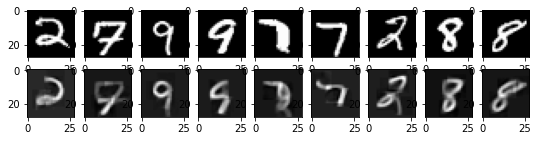

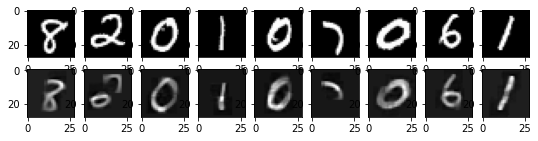

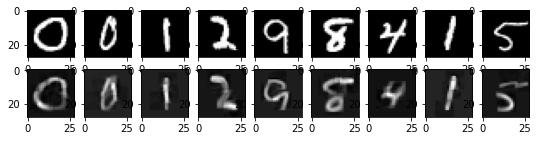

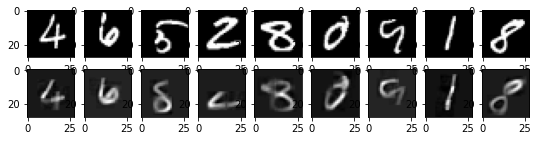

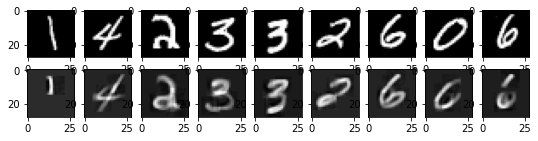

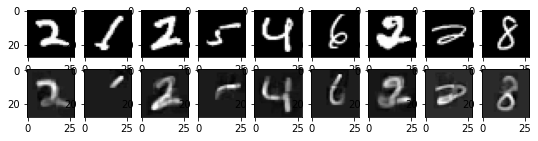

<Figure size 648x144 with 0 Axes>

In [33]:
##### Plotting the images for convolutional Autoencoder

for k in range(0, num_epochs, 1):
    plt.figure(figsize = (9,2))
    plt.gray()
    
    #because it is a Tensor, so we want to detach and then convert into a numpy array
    imgs = outputs[k][1].cpu().detach().numpy()
    recon = outputs[k][2].cpu().detach().numpy()
    print(imgs.shape)
    for i, item in enumerate(imgs):
        if i >= 9:
            break
        plt.subplot(2, 9, i + 1)
        plt.imshow(item[0])
        
    for i, item in enumerate(recon):
        if i >= 9 :
            break
        plt.subplot(2, 9, 9 + i + 1)
        plt.imshow(item[0])

ConvTranspose2d(81, 1, kernel_size=(11, 11), stride=(1, 1), padding=(5, 5))
torch.Size([81, 1, 11, 11])
torch.Size([81, 1, 11, 11])
torch.Size([3, 119, 119])


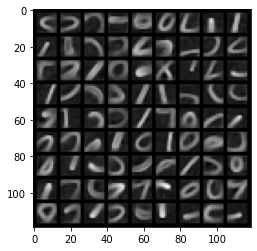

In [37]:
# Filter Plotting Testing
model_case = model_load

children = list(model_case.children())
count = 0
while(not isinstance(children[count], nn.ConvTranspose2d)):
    count +=1
    
# printing the layer type
print(children[count])
kernels = children[count].weight.detach().clone().cpu()
print(kernels.shape)
# normalize to (0,1) range so that matplotlib
# can plot them
kernels = kernels - kernels.min()
kernels = kernels / kernels.max()
print(kernels.shape)
# kernels is a (Tensor or list) – 4D mini-batch Tensor of shape (B x C x H x W) or a list of images all of the same size
filter_img = torchvision.utils.make_grid(kernels, nrow = 9)
# change ordering since matplotlib requires images to 
# be (H, W, C)
print(filter_img.shape)
plt.imshow(filter_img.permute(1, 2, 0))